# Algorithm: The Engine Behind the Machine Learning

## Import Libraries

In [1]:
from datetime import datetime
import numpy as np
import pandas  as pd
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.neighbors import LocalOutlierFactor
from sklearn.feature_selection import RFE, RFECV, SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif

## Load Dataset

In [2]:
df = pd.read_csv('Data/heart_disease_clean.csv')

In [3]:
df.shape

(303, 14)

In [4]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,male,typical angina,145.0,233.0,True,2.0,150.0,no,2.3,downsloping,0.0,6.0,0
1,67.0,male,asymptomatic,160.0,286.0,False,2.0,108.0,yes,1.5,flat,3.0,3.0,1
2,67.0,male,asymptomatic,120.0,229.0,False,2.0,129.0,yes,2.6,flat,2.0,7.0,1
3,37.0,male,non-anginal pain,130.0,250.0,False,0.0,187.0,no,3.5,downsloping,0.0,3.0,0
4,41.0,female,atypical angina,130.0,204.0,False,2.0,172.0,no,1.4,upsloping,0.0,3.0,0


## Result of EDA & Data Preprocessing

In [5]:
numeric_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
nominal_features = ['sex', 'cp', 'exang', 'slope', 'thal', 'fbs', 'restecg']
discrete_features = ['ca']

In [6]:
t = [('cat', OneHotEncoder(drop='first', sparse=False), nominal_features), \
     ('discrete', StandardScaler(), discrete_features),
     ('power', PowerTransformer(), numeric_features),
     ('min_max', MinMaxScaler(), numeric_features)]

col_transform = ColumnTransformer(transformers=t)

## Split Data Set

In [7]:
X = df.drop("num", axis=1)
y = df["num"]

In [8]:
y = LabelEncoder().fit_transform(y)

In [9]:
print(X.shape, y.shape)

(303, 13) (303,)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, stratify=y_train, random_state=42)

In [12]:
print (X_train.shape, X_test.shape, X_valid.shape)

(193, 13) (61, 13) (49, 13)


In [13]:
print (y_train.shape, y_test.shape, y_valid.shape)

(193,) (61,) (49,)


## Model Evaluation Function

In [14]:
def evaluate_model(model, X, y):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        # evaluate model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    #print('F-measure: %.3f' % score)
    return scores

## Find Best Component

### Find Best PCA Component

It can also be a good idea to normalize data prior to performing the PCA transform if the input variables have differing units or scales

In [19]:
estimators = []
estimators.append(('prep', col_transform))
estimators.append(('pca', PCA()))
estimators.append(('lg', LogisticRegression()))
pipeline = Pipeline(estimators)

In [20]:
# define the grid
grid_param = dict()
grid_param['pca__n_components'] = [i+1 for i in range(X.shape[1])]

In [21]:
init_time = datetime.now()
print (f"Job Started at: {init_time}")
kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# RandomizedSearchCV/GridSearchCV
grid_search = GridSearchCV(pipeline,
                        grid_param,
                        cv = kfold,
                        n_jobs = -1,
                        verbose=False)
grid_search.fit(X, y)
# summarize best
print('Best Mean Accuracy: %.3f' % grid_search.best_score_)
print('Best Config: %s' % grid_search.best_params_)
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Job Started at: 2021-01-10 20:50:03.721495
Best Mean Accuracy: 0.842
Best Config: {'pca__n_components': 9}
Execution time :  0:00:06.772169


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [23]:
pca_n_components = grid_search.best_params_['pca__n_components']
pca_n_components 

9

### Find Best SVD Component

Singular Value Decomposition, or SVD, might be the most popular technique for dimensionality reduction when data is sparse. It can also be a good idea to normalize data prior to performing the SVD transform if the input variables have differing units or scales.

In [27]:
estimators = []
estimators.append(('prep', col_transform))
estimators.append(('svd', TruncatedSVD()))
estimators.append(('lg', LogisticRegression()))
pipeline = Pipeline(estimators)

In [28]:
grid_param = dict()
grid_param['svd__n_components'] = [i+1 for i in range(X.shape[1])]

In [29]:
init_time = datetime.now()
print (f"Job Started at: {init_time}")
kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# RandomizedSearchCV/GridSearchCV
grid_search = GridSearchCV(pipeline,
                        grid_param,
                        cv = kfold,
                        n_jobs = -1,
                        verbose=False)
grid_search.fit(X, y)
# summarize best
print('Best Mean Accuracy: %.3f' % grid_search.best_score_)
print('Best Config: %s' % grid_search.best_params_)
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Job Started at: 2021-01-10 20:54:55.436637
Best Mean Accuracy: 0.841
Best Config: {'svd__n_components': 9}
Execution time :  0:00:07.658279


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [30]:
svd_n_components = grid_search.best_params_['svd__n_components']
print(svd_n_components)

9


### Find Best LDA Component

LDA is a technique for multiclass classification that can be used to automatically perform dimensionality reduction. It is good practice to perhaps standardize the data prior to fitting an LDA model. 

In [31]:
estimators = []
estimators.append(('prep', col_transform))
estimators.append(('lda', LinearDiscriminantAnalysis()))
estimators.append(('lg', LogisticRegression()))
pipeline = Pipeline(estimators)

In [32]:
grid_param = dict()
grid_param['lda__n_components'] = [i+1 for i in range(X.shape[1])]

In [33]:
init_time = datetime.now()
print (f"Job Started at: {init_time}")
kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# RandomizedSearchCV/GridSearchCV
grid_search = GridSearchCV(pipeline,
                        grid_param,
                        cv = kfold,
                        n_jobs = -1,
                        verbose=False)
grid_search.fit(X, y)
# summarize best
print('Best Mean Accuracy: %.3f' % grid_search.best_score_)
print('Best Config: %s' % grid_search.best_params_)
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Job Started at: 2021-01-10 20:57:11.266553
Best Mean Accuracy: 0.838
Best Config: {'lda__n_components': 1}
Execution time :  0:00:06.570401


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [34]:
lda_n_components = grid_search.best_params_['lda__n_components']
lda_n_components

1

### ANOVA F-test Feature Selection

In [36]:
init_time = datetime.now()
print (f"Job Started at: {init_time}")
# define the evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define the pipeline to evaluate
fs = SelectKBest(score_func=f_classif)
pipeline = Pipeline(steps=[('prep', col_transform),
                           ('anova',fs), 
                           ('lg', LogisticRegression())])
# define the grid
grid = dict()
grid['anova__k'] = [i+1 for i in range(X.shape[1])]
# define the grid search
# RandomizedSearchCV/GridSearchCV
search = GridSearchCV(pipeline, grid, scoring='accuracy', n_jobs=-1, cv=cv)
# perform the search
results = search.fit(X, y)
# summarize best
print('Best Mean Accuracy: %.3f' % results.best_score_)
print('Best Config: %s' % results.best_params_)
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Job Started at: 2021-01-10 21:02:58.457849
Best Mean Accuracy: 0.840
Best Config: {'anova__k': 12}
Execution time :  0:00:13.148987


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [14 15] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [37]:
anova_best_features = results.best_params_['anova__k']
anova_best_features

12

### Mutual Information Feature Selection

In [38]:
init_time = datetime.now()
print (f"Job Started at: {init_time}")
# define the evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define the pipeline to evaluate
fs = SelectKBest(score_func=mutual_info_classif)
pipeline = Pipeline(steps=[('prep', col_transform),
                           ('mutual',fs), 
                           ('lg', LogisticRegression())])
# define the grid
grid = dict()
grid['mutual__k'] = [i+1 for i in range(X.shape[1])]
# define the grid search
# RandomizedSearchCV/GridSearchCV
search = GridSearchCV(pipeline, grid, scoring='accuracy', n_jobs=-1, cv=cv)
# perform the search
results = search.fit(X, y)
# summarize best
print('Best Mean Accuracy: %.3f' % results.best_score_)
print('Best Config: %s' % results.best_params_)
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Job Started at: 2021-01-10 21:05:09.683729
Best Mean Accuracy: 0.829
Best Config: {'mutual__k': 10}
Execution time :  0:00:21.878789


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [39]:
mutual_best_features = results.best_params_['mutual__k']
mutual_best_features

10

## Classical Model Generation Function

In [15]:
def get_models():
    models = list()
    # LR
    models.append(('LR', LogisticRegression(solver='lbfgs')))
    # LDA
    models.append(('LDA', LinearDiscriminantAnalysis()))
    #KNN
    models.append(('KNN', KNeighborsClassifier()))
    #NB
    models.append(('NB', GaussianNB()))
    #GPC
    models.append(('GPC', GaussianProcessClassifier()))
    #CART
    models.append(('CART', DecisionTreeClassifier()))
    if X.shape[0] < 100000:
        #SVM
        models.append(('SVM', SVC(gamma='auto')))

    return models

In [16]:
init_time = datetime.now()
models = get_models()
for name, model in models:
    pipeline = Pipeline(steps=[('prep', col_transform), ('m', model)])
    scores = evaluate_model(pipeline, X, y)
    print(f"Accuracyof {name}: {np.mean(scores):.3f}")
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Accuracyof LR: 0.836
Accuracyof LDA: 0.837
Accuracyof KNN: 0.804
Accuracyof NB: 0.804
Accuracyof GPC: 0.810
Accuracyof SVM: 0.825
Execution time :  0:00:08.977980


### Dimensionality Reduction

#### PCA 

In [42]:
init_time = datetime.now()
models = get_models()
for name, model in models:
    pipeline = Pipeline(steps=[('prep', col_transform), 
                               ('pca', PCA(n_components=pca_n_components)),
                               ('m', model)])
    scores = evaluate_model(pipeline, X, y)
    print(f"Accuracyof {name}: {np.mean(scores):.3f}")
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Accuracyof LR: 0.842
Accuracyof LDA: 0.833
Accuracyof KNN: 0.780
Accuracyof NB: 0.800
Accuracyof GPC: 0.809
Accuracyof SVM: 0.812
Execution time :  0:00:06.895589


#### SVD

In [43]:
init_time = datetime.now()
models = get_models()
for name, model in models:
    pipeline = Pipeline(steps=[('prep', col_transform), 
                               ('svd', TruncatedSVD(n_components=svd_n_components)),
                               ('m', model)])
    scores = evaluate_model(pipeline, X, y)
    print(f"Accuracyof {name}: {np.mean(scores):.3f}")
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Accuracyof LR: 0.841
Accuracyof LDA: 0.834
Accuracyof KNN: 0.776
Accuracyof NB: 0.797
Accuracyof GPC: 0.805
Accuracyof SVM: 0.797
Execution time :  0:00:04.063018


#### LDA

In [44]:
init_time = datetime.now()
models = get_models()
for name, model in models:
    pipeline = Pipeline(steps=[('prep', col_transform), 
                               ('lda', LinearDiscriminantAnalysis(n_components= lda_n_components)),
                               ('m', model)])
    scores = evaluate_model(pipeline, X, y)
    print(f"Accuracyof {name}: {np.mean(scores):.3f}")
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Accuracyof LR: 0.838
Accuracyof LDA: 0.837
Accuracyof KNN: 0.827
Accuracyof NB: 0.836
Accuracyof GPC: 0.837
Accuracyof SVM: 0.837
Execution time :  0:00:04.343639


### Feature Selection

#### RFE

In [45]:
init_time = datetime.now()
models = get_models()
for name, model in models:
    pipeline = Pipeline(steps=[('prep', col_transform), 
                               ('rfe', RFECV(estimator=RandomForestClassifier())),
                               ('m', model)])
    scores = evaluate_model(pipeline, X, y)
    print(f"Accuracyof {name}: {np.mean(scores):.3f}")
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Accuracyof LR: 0.836
Accuracyof LDA: 0.833
Accuracyof KNN: 0.792
Accuracyof NB: 0.824
Accuracyof GPC: 0.812
Accuracyof SVM: 0.824
Execution time :  0:24:16.743286


#### ANOVA Feature Selection

In [46]:
def select_Anova_features(X_train, y_train, X_test, k):
    # configure to select all features
    fs = SelectKBest(score_func=f_classif, k=k)
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

#### Mutual Information Feature Selection

In [ ]:
def select_Mutual_features(X_train, y_train, X_test, k):
    # configure to select all features
    fs = SelectKBest(score_func=mutual_info_classif, k=k)
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

## Ensemble Model Generation Function

In [68]:
def get_ensemble_models():
    models = list()
    #SGD
    models.append(('SGD', SGDClassifier()))
    #ADA
    models.append(('AD', AdaBoostClassifier())) 
    #ET 
    models.append(('ET', ExtraTreesClassifier()))
    #RF
    models.append(('RF', RandomForestClassifier(n_estimators=1000)))
    #GBM
    models.append(('GBM', GradientBoostingClassifier(n_estimators=1000)))
    #XGB
    models.append(('XGB', XGBClassifier()))
    #LGB
    models.append(('LGB', LGBMClassifier()))
    #CAT
    models.append(('cat', CatBoostClassifier()))
    
    return models

In [69]:
init_time = datetime.now()
models = get_ensemble_models()
for name, model in models:
    pipeline = Pipeline(steps=[('prep', col_transform), ('m', model)])
    scores = evaluate_model(pipeline, X, y)
    print(f"Accuracyof {name}: {np.mean(scores):.3f}")
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Accuracyof CART: 0.745
Accuracyof SGD: 0.783
Accuracyof AD: 0.791
Accuracyof ET: 0.800
Accuracyof RF: 0.801
Accuracyof GBM: 0.756
Accuracyof XGB: 0.789
Accuracyof LGB: 0.794
Accuracyof cat: 0.816
Execution time :  0:01:38.397438


## Experiment with Robust Scaler

In [ ]:
t = [('cat', OneHotEncoder(drop='first', sparse=False), nominal_features), \
     ('ordinal', OrdinalEncoder(), ordinal_features),
     ('power', PowerTransformer(), numeric_features),
     ('min_max', RobustScaler(), numeric_features)]

col_transform = ColumnTransformer(transformers=t)

### Classical Model Generation Function

In [ ]:
init_time = datetime.now()
models = get_models()
for name, model in models:
    pipeline = Pipeline(steps=[('prep', col_transform), ('m', model)])
    scores = evaluate_model(pipeline, X, y)
    print(f"Accuracyof {name}: {np.mean(scores):.3f}")
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

### Ensemble Model Generation Function

In [ ]:
init_time = datetime.now()
models = get_ensemble_models()
for name, model in models:
    pipeline = Pipeline(steps=[('prep', col_transform), ('m', model)])
    scores = evaluate_model(pipeline, X, y)
    print(f"Accuracyof {name}: {np.mean(scores):.3f}")
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

## Pandas Get Dummies

In [48]:
nominal_features_new = ['sex', 'cp', 'exang', 'slope', 'thal', 'fbs', 'restecg', 'ca']

In [49]:
dummies = pd.get_dummies(df[nominal_features_new], drop_first=True)
df_new = df.drop(nominal_features_new, axis=1)
df_new = pd.concat([df_new, dummies], axis=1)

In [50]:
X_new = df_new.drop("num", axis=1)
y_new = df_new["num"]

In [51]:
y_new = LabelEncoder().fit_transform(y_new)

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.20, stratify=y, random_state=42)

## Classical Model Generation Function

In [52]:
init_time = datetime.now()
models = get_models()
for name, model in models:
    pipeline = Pipeline(steps=[('power', PowerTransformer()), 
                               ('scaler', RobustScaler()),
                               ('m', model)])
    scores = evaluate_model(pipeline, X_new, y_new)
    print(f"Accuracyof {name}: {np.mean(scores):.3f}")
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Accuracyof LR: 0.834
Accuracyof LDA: 0.841
Accuracyof KNN: 0.823
Accuracyof NB: 0.831
Accuracyof GPC: 0.822
Accuracyof SVM: 0.844
Execution time :  0:00:04.095912


### Dimensionality Reduction

#### PCA 

In [54]:
init_time = datetime.now()
models = get_models()
for name, model in models:
    pipeline = Pipeline(steps=[('power', PowerTransformer()), 
                               ('scaler', RobustScaler()),
                               ('pca', PCA(n_components=pca_n_components)),
                               ('m', model)])
    scores = evaluate_model(pipeline, X_new, y_new)
    print(f"Accuracyof {name}: {np.mean(scores):.3f}")
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Accuracyof LR: 0.838
Accuracyof LDA: 0.843
Accuracyof KNN: 0.813
Accuracyof NB: 0.825
Accuracyof GPC: 0.821
Accuracyof SVM: 0.847
Execution time :  0:00:03.159127


#### SVD

In [55]:
init_time = datetime.now()
models = get_models()
for name, model in models:
    pipeline = Pipeline(steps=[('power', PowerTransformer()), 
                               ('scaler', RobustScaler()),
                               ('svd', TruncatedSVD(n_components=svd_n_components)),
                               ('m', model)])
    scores = evaluate_model(pipeline, X_new, y_new)
    print(f"Accuracyof {name}: {np.mean(scores):.3f}")
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Accuracyof LR: 0.832
Accuracyof LDA: 0.833
Accuracyof KNN: 0.802
Accuracyof NB: 0.824
Accuracyof GPC: 0.812
Accuracyof SVM: 0.834
Execution time :  0:00:04.891148


#### LDA

In [56]:
init_time = datetime.now()
models = get_models()
for name, model in models:
    pipeline = Pipeline(steps=[('power', PowerTransformer()), 
                               ('scaler', RobustScaler()),
                               ('lda', LinearDiscriminantAnalysis(n_components= lda_n_components)),
                               ('m', model)])
    scores = evaluate_model(pipeline, X_new, y_new)
    print(f"Accuracyof {name}: {np.mean(scores):.3f}")
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Accuracyof LR: 0.838
Accuracyof LDA: 0.841
Accuracyof KNN: 0.814
Accuracyof NB: 0.841
Accuracyof GPC: 0.840
Accuracyof SVM: 0.841
Execution time :  0:00:02.776493


### Feature Selection

#### ANOVA Feature Selection

In [60]:
def select_Anova_features(X_train, y_train, X_test, k):
    # configure to select all features
    fs = SelectKBest(score_func=f_classif, k=k)
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [61]:
init_time = datetime.now()
print (f"Job Started at: {init_time}")
# feature selection
X_fs, X_fs, fs = select_Anova_features(X_new, y_new, X_new, anova_best_features)
models = get_models()
for name, model in models:
    pipeline = Pipeline(steps=[('m', model)])
    scores = evaluate_model(pipeline, X_fs, y)
    print(f"Accuracyof {name}: {np.mean(scores):.3f}")

fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Job Started at: 2021-01-10 22:09:44.689977
Accuracyof LR: 0.830
Accuracyof LDA: 0.822
Accuracyof KNN: 0.704
Accuracyof NB: 0.821
Accuracyof GPC: 0.668
Accuracyof SVM: 0.693
Execution time :  0:00:01.307071


In [58]:
init_time = datetime.now()
print (f"Job Started at: {init_time}")
# feature selection
X_fs, X_fs, fs = select_Anova_features(X_new, y_new, X_new, anova_best_features)
models = get_models()
for name, model in models:
    pipeline = Pipeline(steps=[('power', PowerTransformer()), 
                               ('scaler', RobustScaler()), 
                               ('m', model)])
    scores = evaluate_model(pipeline, X_fs, y)
    print(f"Accuracyof {name}: {np.mean(scores):.3f}")

fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Job Started at: 2021-01-10 22:07:26.421786
Accuracyof LR: 0.830
Accuracyof LDA: 0.824
Accuracyof KNN: 0.826
Accuracyof NB: 0.821
Accuracyof GPC: 0.821
Accuracyof SVM: 0.821
Execution time :  0:00:02.186689


#### Mutual Information Feature Selection

In [59]:
def select_Mutual_features(X_train, y_train, X_test, k):
    # configure to select all features
    fs = SelectKBest(score_func=mutual_info_classif, k=k)
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [62]:
init_time = datetime.now()
print (f"Job Started at: {init_time}")

# feature selection
X_fs, X_fs, fs = select_Mutual_features(X_new, y_new, X_new, mutual_best_features)
models = get_models()
for name, model in models:
    pipeline = Pipeline(steps=[('m', model)])
    scores = evaluate_model(pipeline, X_fs, y)
    print(f"Accuracyof {name}: {np.mean(scores):.3f}")

fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Job Started at: 2021-01-10 22:10:25.912739
Accuracyof LR: 0.822
Accuracyof LDA: 0.818
Accuracyof KNN: 0.655
Accuracyof NB: 0.819
Accuracyof GPC: 0.644
Accuracyof SVM: 0.590
Execution time :  0:00:01.523574


In [63]:
init_time = datetime.now()
print (f"Job Started at: {init_time}")

# feature selection
X_fs, X_fs, fs = select_Mutual_features(X_new, y_new, X_new, mutual_best_features)
models = get_models()
for name, model in models:
    pipeline = Pipeline(steps=[('power', PowerTransformer()), 
                               ('scaler', RobustScaler()), 
                               ('m', model)])
    scores = evaluate_model(pipeline, X_fs, y)
    print(f"Accuracyof {name}: {np.mean(scores):.3f}")

fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Job Started at: 2021-01-10 22:10:37.141082
Accuracyof LR: 0.838
Accuracyof LDA: 0.836
Accuracyof KNN: 0.822
Accuracyof NB: 0.838
Accuracyof GPC: 0.833
Accuracyof SVM: 0.846
Execution time :  0:00:02.978918


#### RFE

In [64]:
init_time = datetime.now()
models = get_models()
for name, model in models:
    pipeline = Pipeline(steps=[('power', PowerTransformer()), 
                               ('scaler', RobustScaler()), 
                               ('rfe', RFECV(estimator=RandomForestClassifier())),
                               ('m', model)])
    scores = evaluate_model(pipeline, X_new, y_new)
    print(f"Accuracyof {name}: {np.mean(scores):.3f}")
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Accuracyof LR: 0.833
Accuracyof LDA: 0.827
Accuracyof KNN: 0.827
Accuracyof NB: 0.822
Accuracyof GPC: 0.822
Accuracyof SVM: 0.835
Execution time :  0:17:59.560433


### Feature Selection with Dimensionality Reduction

#### PCA + RFE

In [65]:
init_time = datetime.now()
models = get_models()
for name, model in models:
    pipeline = Pipeline(steps=[('power', PowerTransformer()), 
                               ('scaler', RobustScaler()),
                               ('pca', PCA(n_components=pca_n_components)),
                               ('rfe', RFECV(estimator=RandomForestClassifier())),
                               ('m', model)])
    scores = evaluate_model(pipeline, X_new, y_new)
    print(f"Accuracyof {name}: {np.mean(scores):.3f}")
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Accuracyof LR: 0.833
Accuracyof LDA: 0.833
Accuracyof KNN: 0.811
Accuracyof NB: 0.822
Accuracyof GPC: 0.825
Accuracyof SVM: 0.836
Execution time :  0:09:56.223389


#### PCA + ANOVA

In [66]:
init_time = datetime.now()
print (f"Job Started at: {init_time}")
# feature selection
X_fs, X_fs, fs = select_Anova_features(X_new, y_new, X_new, anova_best_features)

for name, model in models:
    pipeline = Pipeline(steps=[('power', PowerTransformer()), 
                               ('scaler', RobustScaler()), 
                               ('pca', PCA(n_components=pca_n_components)),
                               ('m', model)])
    scores = evaluate_model(pipeline, X_fs, y)
    print(f"Accuracyof {name}: {np.mean(scores):.3f}")

fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Job Started at: 2021-01-10 23:00:56.859362
Accuracyof LR: 0.838
Accuracyof LDA: 0.837
Accuracyof KNN: 0.811
Accuracyof NB: 0.817
Accuracyof GPC: 0.822
Accuracyof SVM: 0.823
Execution time :  0:00:01.707521


#### PCA + Mutual Information Feature Selection

In [67]:
init_time = datetime.now()
print (f"Job Started at: {init_time}")

# feature selection
X_fs, X_fs, fs = select_Mutual_features(X_new, y_new, X_new, mutual_best_features)

for name, model in models:
    pipeline = Pipeline(steps=[('power', PowerTransformer()), 
                               ('scaler', RobustScaler()), 
                               ('pca', PCA(n_components=pca_n_components)),
                               ('m', model)])
    scores = evaluate_model(pipeline, X_fs, y)
    print(f"Accuracyof {name}: {np.mean(scores):.3f}")

fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Job Started at: 2021-01-10 23:01:07.183202
Accuracyof LR: 0.815
Accuracyof LDA: 0.824
Accuracyof KNN: 0.816
Accuracyof NB: 0.792
Accuracyof GPC: 0.817
Accuracyof SVM: 0.827
Execution time :  0:00:01.980983


## Ensemble Model Generation Function

In [70]:
init_time = datetime.now()
models = get_ensemble_models()
for name, model in models:
    pipeline = Pipeline(steps=[('power', PowerTransformer()), 
                               ('scaler', RobustScaler()),
                               ('m', model)])
    scores = evaluate_model(pipeline, X_new, y_new)
    print(f"Accuracyof {name}: {np.mean(scores):.3f}")
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Accuracyof CART: 0.730
Accuracyof SGD: 0.797
Accuracyof AD: 0.794
Accuracyof ET: 0.818
Accuracyof RF: 0.807
Accuracyof GBM: 0.762
Accuracyof XGB: 0.778
Accuracyof LGB: 0.802
Accuracyof cat: 0.813
Execution time :  0:01:26.903131


### Find Best Component

#### Find Best PCA Component

In [71]:
estimators = []
estimators.append(('power', PowerTransformer()))
estimators.append(('scaler', RobustScaler()))
estimators.append(('pca', PCA()))
estimators.append(('rfc', RandomForestClassifier(n_estimators=1000)))
pipeline = Pipeline(estimators)

In [72]:
# define the grid
grid_param = dict()
grid_param['pca__n_components'] = [i+1 for i in range(X.shape[1])]

In [74]:
init_time = datetime.now()
print (f"Job Started at: {init_time}")
kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# RandomizedSearchCV/GridSearchCV
grid_search = GridSearchCV(pipeline,
                        grid_param,
                        cv = kfold,
                        n_jobs = -1,
                        verbose=False)
grid_search.fit(X_new, y_new)
# summarize best
print('Best Mean Accuracy: %.3f' % grid_search.best_score_)
print('Best Config: %s' % grid_search.best_params_)
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Job Started at: 2021-01-10 23:06:17.721010


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


Best Mean Accuracy: 0.823
Best Config: {'pca__n_components': 12}
Execution time :  0:04:51.631379


In [75]:
pca_n_components = grid_search.best_params_['pca__n_components']
pca_n_components 

12

#### ANOVA F-test Feature Selection

In [79]:
init_time = datetime.now()
print (f"Job Started at: {init_time}")
# define the evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define the pipeline to evaluate
fs = SelectKBest(score_func=f_classif)
pipeline = Pipeline(steps=[('power', PowerTransformer()),
                           ('scaler', RobustScaler()),
                           ('anova', fs), 
                           ('rfc', RandomForestClassifier(n_estimators=1000))])
# define the grid
grid = dict()
grid['anova__k'] = [i+1 for i in range(X.shape[1])]
# define the grid search
# RandomizedSearchCV/GridSearchCV
search = GridSearchCV(pipeline, grid, scoring='accuracy', n_jobs=-1, cv=cv)
# perform the search
results = search.fit(X_new, y_new)
# summarize best
print('Best Mean Accuracy: %.3f' % results.best_score_)
print('Best Config: %s' % results.best_params_)
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Job Started at: 2021-01-10 23:49:11.588075


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [1 2] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Best Mean Accuracy: 0.814
Best Config: {'anova__k': 11}
Execution time :  0:05:50.250095


In [80]:
anova_best_features = results.best_params_['anova__k']
anova_best_features

11

#### Mutual Information Feature Selection

In [81]:
init_time = datetime.now()
print (f"Job Started at: {init_time}")
# define the evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define the pipeline to evaluate
fs = SelectKBest(score_func=mutual_info_classif)
pipeline = Pipeline(steps=[('power', PowerTransformer()),
                           ('scaler', RobustScaler()),
                           ('mutual', fs), 
                           ('rfc', RandomForestClassifier(n_estimators=1000))])
# define the grid
grid = dict()
grid['mutual__k'] = [i+1 for i in range(X.shape[1])]
# define the grid search
# RandomizedSearchCV/GridSearchCV
search = GridSearchCV(pipeline, grid, scoring='accuracy', n_jobs=-1, cv=cv)
# perform the search
results = search.fit(X_new, y_new)
# summarize best
print('Best Mean Accuracy: %.3f' % results.best_score_)
print('Best Config: %s' % results.best_params_)
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Job Started at: 2021-01-10 23:55:16.323808


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


Best Mean Accuracy: 0.809
Best Config: {'mutual__k': 11}
Execution time :  0:05:56.202495


In [82]:
mutual_best_features = results.best_params_['mutual__k']
mutual_best_features

11

### Dimensionality Reduction

#### PCA 

In [76]:
init_time = datetime.now()
models = get_ensemble_models()
for name, model in models:
    pipeline = Pipeline(steps=[('power', PowerTransformer()), 
                               ('scaler', RobustScaler()),
                               ('pca', PCA(n_components=pca_n_components)),
                               ('m', model)])
    scores = evaluate_model(pipeline, X_new, y_new)
    print(f"Accuracyof {name}: {np.mean(scores):.3f}")
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Accuracyof CART: 0.734
Accuracyof SGD: 0.804
Accuracyof AD: 0.781
Accuracyof ET: 0.814
Accuracyof RF: 0.814
Accuracyof GBM: 0.802
Accuracyof XGB: 0.809
Accuracyof LGB: 0.808
Accuracyof cat: 0.813
Execution time :  0:02:05.327830


#### SVD

In [77]:
init_time = datetime.now()
models = get_ensemble_models()
for name, model in models:
    pipeline = Pipeline(steps=[('power', PowerTransformer()), 
                               ('scaler', RobustScaler()),
                               ('svd', TruncatedSVD(n_components=pca_n_components)),
                               ('m', model)])
    scores = evaluate_model(pipeline, X_new, y_new)
    print(f"Accuracyof {name}: {np.mean(scores):.3f}")
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Accuracyof CART: 0.759
Accuracyof SGD: 0.785
Accuracyof AD: 0.796
Accuracyof ET: 0.813
Accuracyof RF: 0.815
Accuracyof GBM: 0.806
Accuracyof XGB: 0.798
Accuracyof LGB: 0.801
Accuracyof cat: 0.809
Execution time :  0:02:09.777133


### Feature Selection

#### ANOVA Feature Selection

In [83]:
init_time = datetime.now()
print (f"Job Started at: {init_time}")
# feature selection
X_fs, X_fs, fs = select_Anova_features(X_new, y_new, X_new, anova_best_features)
models = get_ensemble_models()
for name, model in models:
    pipeline = Pipeline(steps=[('m', model)])
    scores = evaluate_model(pipeline, X_fs, y)
    print(f"Accuracyof {name}: {np.mean(scores):.3f}")

fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Job Started at: 2021-01-11 00:01:12.563162
Accuracyof CART: 0.709
Accuracyof SGD: 0.674
Accuracyof AD: 0.786
Accuracyof ET: 0.795
Accuracyof RF: 0.813
Accuracyof GBM: 0.736
Accuracyof XGB: 0.780
Accuracyof LGB: 0.790
Accuracyof cat: 0.823
Execution time :  0:03:01.027734


In [84]:
init_time = datetime.now()
print (f"Job Started at: {init_time}")
# feature selection
X_fs, X_fs, fs = select_Anova_features(X_new, y_new, X_new, anova_best_features)
models = get_ensemble_models()
for name, model in models:
    pipeline = Pipeline(steps=[('power', PowerTransformer()), 
                               ('scaler', RobustScaler()), 
                               ('m', model)])
    scores = evaluate_model(pipeline, X_fs, y)
    print(f"Accuracyof {name}: {np.mean(scores):.3f}")

fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Job Started at: 2021-01-11 00:04:13.621346
Accuracyof CART: 0.708
Accuracyof SGD: 0.789
Accuracyof AD: 0.786
Accuracyof ET: 0.807
Accuracyof RF: 0.810
Accuracyof GBM: 0.736
Accuracyof XGB: 0.781
Accuracyof LGB: 0.792
Accuracyof cat: 0.823
Execution time :  0:02:29.080018


#### Mutual Information Feature Selection

In [90]:
init_time = datetime.now()
print (f"Job Started at: {init_time}")

# feature selection
X_fs, X_fs, fs = select_Mutual_features(X_new, y_new, X_new, mutual_best_features)
models = get_ensemble_models()
for name, model in models:
    pipeline = Pipeline(steps=[('m', model)])
    scores = evaluate_model(pipeline, X_fs, y)
    print(f"Accuracyof {name}: {np.mean(scores):.3f}")

fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Job Started at: 2021-01-11 03:47:57.605955
Accuracyof CART: 0.723
Accuracyof SGD: 0.598
Accuracyof AD: 0.781
Accuracyof ET: 0.804
Accuracyof RF: 0.804
Accuracyof GBM: 0.769
Accuracyof XGB: 0.781
Accuracyof LGB: 0.790
Accuracyof cat: 0.814
Execution time :  0:02:21.716284


In [91]:
init_time = datetime.now()
print (f"Job Started at: {init_time}")

# feature selection
X_fs, X_fs, fs = select_Mutual_features(X_new, y_new, X_new, mutual_best_features)
models = get_ensemble_models()
for name, model in models:
    pipeline = Pipeline(steps=[('power', PowerTransformer()), 
                               ('scaler', RobustScaler()), 
                               ('m', model)])
    scores = evaluate_model(pipeline, X_fs, y)
    print(f"Accuracyof {name}: {np.mean(scores):.3f}")

fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Job Started at: 2021-01-11 03:50:19.471056
Accuracyof CART: 0.713
Accuracyof SGD: 0.793
Accuracyof AD: 0.790
Accuracyof ET: 0.810
Accuracyof RF: 0.819
Accuracyof GBM: 0.767
Accuracyof XGB: 0.769
Accuracyof LGB: 0.788
Accuracyof cat: 0.810
Execution time :  0:03:56.280753


#### RFE

In [87]:
init_time = datetime.now()
models = get_ensemble_models()
for name, model in models:
    pipeline = Pipeline(steps=[('power', PowerTransformer()), 
                               ('scaler', RobustScaler()), 
                               ('rfe', RFECV(estimator=RandomForestClassifier())),
                               ('m', model)])
    scores = evaluate_model(pipeline, X_new, y_new)
    print(f"Accuracyof {name}: {np.mean(scores):.3f}")
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Accuracyof CART: 0.722
Accuracyof SGD: 0.774
Accuracyof AD: 0.788
Accuracyof ET: 0.811
Accuracyof RF: 0.807
Accuracyof GBM: 0.760
Accuracyof XGB: 0.768
Accuracyof LGB: 0.794
Accuracyof cat: 0.811
Execution time :  0:37:12.406061


### Feature Selection with Dimensionality Reduction

#### PCA + RFE

In [88]:
init_time = datetime.now()
models = get_ensemble_models()
for name, model in models:
    pipeline = Pipeline(steps=[('power', PowerTransformer()), 
                               ('scaler', RobustScaler()), 
                               ('pca', PCA(n_components=pca_n_components)),
                               ('rfe', RFECV(estimator=RandomForestClassifier())),
                               ('m', model)])
    scores = evaluate_model(pipeline, X_new, y_new)
    print(f"Accuracyof {name}: {np.mean(scores):.3f}")
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Accuracyof CART: 0.735
Accuracyof SGD: 0.785
Accuracyof AD: 0.777
Accuracyof ET: 0.816
Accuracyof RF: 0.807
Accuracyof GBM: 0.789
Accuracyof XGB: 0.798
Accuracyof LGB: 0.804
Accuracyof cat: 0.812
Execution time :  0:37:24.134185


#### PCA + ANOVA

In [93]:
anova_best_features

11

In [94]:
init_time = datetime.now()
print (f"Job Started at: {init_time}")
# feature selection
X_fs, X_fs, fs = select_Anova_features(X_new, y_new, X_new, anova_best_features)
models = get_ensemble_models()
for name, model in models:
    pipeline = Pipeline(steps=[('power', PowerTransformer()), 
                               ('scaler', RobustScaler()), 
                               ('pca', PCA(n_components=pca_n_components)),
                               ('m', model)])
    scores = evaluate_model(pipeline, X_fs, y)
    print(f"Accuracyof {name}: {np.mean(scores):.3f}")

fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Job Started at: 2021-01-11 08:41:10.968655
Accuracyof CART: nan
Accuracyof SGD: nan
Accuracyof AD: nan
Accuracyof ET: nan
Accuracyof RF: nan
Accuracyof GBM: nan
Accuracyof XGB: nan
Accuracyof LGB: nan
Accuracyof cat: nan
Execution time :  0:00:18.347565


#### PCA + Mutual Information Feature Selection

In [92]:
init_time = datetime.now()
print (f"Job Started at: {init_time}")

# feature selection
X_fs, X_fs, fs = select_Mutual_features(X_new, y_new, X_new, mutual_best_features)
models = get_ensemble_models()
for name, model in models:
    pipeline = Pipeline(steps=[('power', PowerTransformer()), 
                               ('scaler', RobustScaler()), 
                               ('pca', PCA(n_components=pca_n_components)),
                               ('m', model)])
    scores = evaluate_model(pipeline, X_fs, y)
    print(f"Accuracyof {name}: {np.mean(scores):.3f}")

fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Job Started at: 2021-01-11 03:54:15.772560
Accuracyof CART: nan
Accuracyof SGD: nan
Accuracyof AD: nan
Accuracyof ET: nan
Accuracyof RF: nan
Accuracyof GBM: nan
Accuracyof XGB: nan
Accuracyof LGB: nan
Accuracyof cat: nan
Execution time :  0:00:06.266074


## Final Selected Algorithm

In [97]:
pca_n_components

12

In [96]:
init_time = datetime.now()
model = SVC(gamma='auto')
pipeline = Pipeline(steps=[('power', PowerTransformer()), 
                               ('scaler', RobustScaler()),
                               ('pca', PCA(n_components=pca_n_components)),
                               ('m', model)])
pipeline.fit(X_train, y_train)
results = pipeline.predict(X_test)
print(classification_report(y_test, results))
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

              precision    recall  f1-score   support

           0       0.90      0.85      0.88        33
           1       0.83      0.89      0.86        28

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61

Execution time :  0:00:03.663354


simply attemp to distinguish presence (values 1) from absence (value 0)

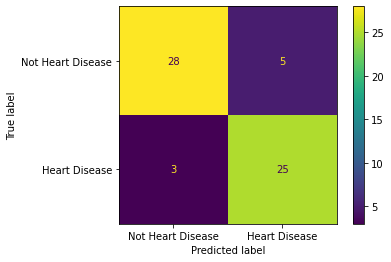

In [101]:
plot_confusion_matrix(pipeline, X_test, y_test, values_format='d', display_labels=["Not Heart Disease","Heart Disease"]);